In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

In [6]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
# Class 1 
Measurement = Base.classes.measurement

In [9]:
# Save references to each table
# Class 2
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
#First row for Measurement 
first_row_measure = session.query(Measurement).first()
first_row_measure.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fbff3c3db00>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0}

In [12]:
#First row for Station
first_row_measure = session.query(Station).first()
first_row_measure.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fbff3cb3f28>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

## Inspect Database

In [13]:
#Not necessary but will make this revision to see the data types 
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [14]:
# Get a list of column names and types in Measurement 
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [15]:
# Get a list of column names and types in Station 
columns_station = inspector.get_columns('station')
for t in columns_station:
    print(t['name'], t["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [16]:
# Find the most recent date in the data set.
# Measurement is the table with the data column 

session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
# Calculate the date one year from the last date in data set.

year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Year ago: ", year_ago)


Year ago:  2016-08-23


In [18]:
# Perform a query to retrieve the data and precipitation scores
# year_ago_dt = dt.datetime(2016, 8, 23). Was going to pass it as a variable 
# but on Gitlab it says: Note you do not pass in the date as a variable to your query. 

results = session.query(Measurement.date, Measurement.prcp).\
                  filter(Measurement.date > "2016-08-23").all()

In [19]:

# #Checking if my query works :) 
# results_rows = [{"Date": result[0], "PRCP": result[1]} for result in results]
# results_rows

In [20]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index('date', inplace=True, )


In [21]:
#Sorting by date. If not, the date on the x axis look all scrambled. 
df.sort_index(inplace=True)

Text(0, 0.5, 'inches')

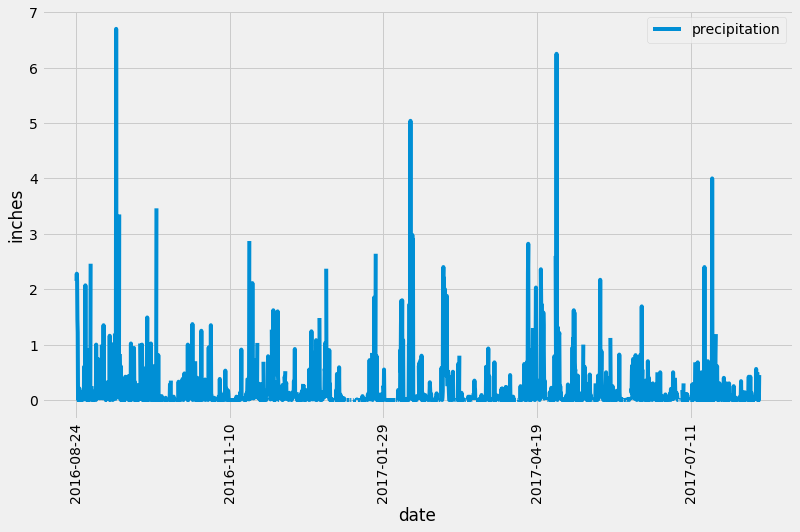

In [22]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(kind="line",figsize=(12,7), rot="vertical")
plt.xlabel("date")
plt.ylabel("inches")



In [23]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [24]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(Station.station)).all()

[(9)]

In [25]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by((func.count(Measurement.station).desc())).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
# Using the most active station id from the previous query, 
# calculate the lowest, highest, and average temperature.
# "USC00519281" is the most active station. 
sel = [Measurement.station, 
       func.avg(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.min(Measurement.tobs)]
specific_station = session.query(*sel).\
    filter(Measurement.station == "USC00519281").all()
specific_station


[('USC00519281', 71.66378066378067, 85.0, 54.0)]

In [27]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Checking the most recent date observation for the most active station. 

session.query(Measurement.date).\
    filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date.desc()).first()


('2017-08-18')

In [28]:
# Using Pandas `read_sql_query` to load a query statement directly into the DataFrame
stmt = session.query(Measurement).\
    filter(Measurement.date > "2016-08-18").\
    filter(Measurement.station == "USC00519281").statement
df2 = pd.read_sql_query(stmt, session.bind)
df2.head()


,id,station,date,prcp,tobs
0,14604,USC00519281,2016-08-19,0.31,79.0
1,14605,USC00519281,2016-08-20,0.13,81.0
2,14606,USC00519281,2016-08-21,0.08,79.0
3,14607,USC00519281,2016-08-22,2.32,78.0
4,14608,USC00519281,2016-08-23,1.79,77.0


In [29]:
df2["station"].count()

356

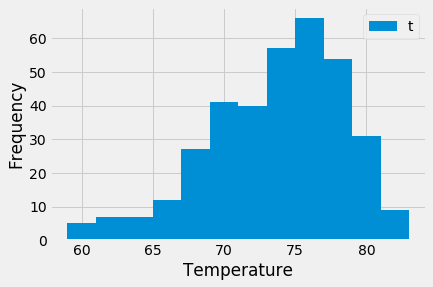

In [30]:
x= df2["tobs"]
plt.hist(x, bins = 12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend("tobs", loc='upper right')
plt.show()

# Close session

In [31]:
# Close Session
session.close()